In [10]:
initial_investment = 1000000
yearly_sale_percentage = 0.04
capital_gains_tax = 0.26
dividend_tax = 0.26
monthly_sale_percentage = yearly_sale_percentage / 12
ticker = 'VYM'

In [11]:
import os
import requests as req

# Load environment variables
# Read .env file manually and set environment variables
with open('.env') as f:
    for line in f:
        key, value = line.strip().split('=')
        os.environ[key] = value
# Get API_KEY from .env file
API_KEY = os.getenv("API_KEY")
# Save CSV file if it doesn't exist
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_MONTHLY_ADJUSTED&symbol={ticker}&apikey={API_KEY}&datatype=csv'
filename = f"monthly_adjusted_{ticker}.csv"
if not os.path.exists(filename):
    with open(filename, 'wb') as f:
        # Ensure the request was successful
        r = req.get(url)
        r.raise_for_status()
        f.write(r.content)

In [12]:
import pandas as pd

def load_source_data(prices_file, bigmac_file):
    # Stock prices
    ts = pd.read_csv(prices_file)
    ts = ts.sort_values(by="timestamp")
    ts = ts.reset_index()
    ts = ts.drop(columns="index")
    df = pd.DataFrame({
    "timestamp": ts["timestamp"],
    "price": ts["adjusted close"],
    "dividend yield": ts["dividend amount"] / ts["adjusted close"],
    })
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Big Mac index
    bigmac_pricedata = pd.read_csv(bigmac_file)
    country = "United States"
    bmprice = bigmac_pricedata[bigmac_pricedata.name == country][['date', 'dollar_price']]
    bmprice['date'] = pd.to_datetime(bmprice['date'])
    bmprice.rename(columns={"date": "timestamp", "dollar_price": "cpi"}, inplace=True)
    
    # Discard data that is not in the same time range for both datasets
    bmprice = bmprice[(bmprice['timestamp'] >= df['timestamp'].iloc[0]) & (bmprice['timestamp'] <= df['timestamp'].iloc[-1])]
    df = df[(df['timestamp'] >= bmprice['timestamp'].iloc[0]) & (df['timestamp'] <= bmprice['timestamp'].iloc[-1])]
    
    # Merge datasets
    df = pd.merge_asof(df, bmprice, on="timestamp")
    # Normalize CPI to 1 and stock price to 100
    df['cpi'] = df['cpi'].fillna(bmprice['cpi'].iloc[0])
    df['cpi'] = (df['cpi'] / df['cpi'].iloc[0]).round(3)
    df['price'] = (df['price'] / df['price'].iloc[0] * 100).round(3)
    return df

In [13]:
src = load_source_data(f"monthly_adjusted_{ticker}.csv", "bigmac.csv")
src = src[src.timestamp > "2010-01-01"]
src

,timestamp,price,dividend yield,cpi
36,2010-01-29,77.954,0.000000,1.187
37,2010-02-26,79.859,0.000000,1.187
38,2010-03-31,84.261,0.008886,1.187
39,2010-04-30,85.687,0.000000,1.187
40,2010-05-28,78.939,0.000000,1.187
...,...,...,...,...
181,2022-02-28,337.240,0.000000,1.744
182,2022-03-31,346.554,0.006248,1.744
183,2022-04-29,331.981,0.000000,1.744
184,2022-05-31,343.651,0.000000,1.744


In [14]:
def transform_row(current_month: pd.Series, previous_month: pd.Series | None, first_month: pd.Series | None):
    month = current_month.copy()
    # Initialize new columns, avoid NaNs
    month['shares sold'] = 0
    month['capital gains'] = 0
    month['capital gains tax'] = 0
    month['shares purchased'] = 0

    month['shares'] = initial_investment / month['price'] if previous_month is None else previous_month['shares']
    month['cum capital losses'] = 0 if previous_month is None else previous_month['cum capital losses']
    month['cost basis rate'] = month['price'] if previous_month is None else previous_month['cost basis rate']
    month['portfolio value'] = month['shares'] * month['price']
    # Target income
    month['gross income'] = month['portfolio value'] * month['perc. sold']

    # Receive dividends
    month['gross dividend'] = month['shares'] * month['dividend yield'] * month['price']
    month['dividend tax'] = month['gross dividend'] * dividend_tax
    month['net dividend'] = month['gross dividend'] * (1 - dividend_tax)
    
    if month['gross income'] > month['net dividend']:
        # Dividends do not cover the entire target income
        # Use dividends to cover part of the target income
        remaining_target_income = month['gross income'] - month['net dividend']
        # Sell shares to cover the remaining target income
        month['shares sold'] = remaining_target_income / month['price']
        month['shares'] -= month['shares sold']
        month['capital gains'] = month['shares sold'] * (month['price'] - month['cost basis rate'])

        if month['capital gains'] < 0:
            month['cum capital losses'] -= month['capital gains']
            month['capital gains tax'] = 0
        elif month['cum capital losses'] > 0:
            net_capital_gains = month['capital gains'] - month['cum capital losses']
            if net_capital_gains < 0:
                month['cum capital losses'] = -net_capital_gains
                month['capital gains tax'] = 0
            else:
                month['capital gains tax'] = net_capital_gains * capital_gains_tax
                month['cum capital losses'] = 0
        else:
            month['capital gains tax'] = month['capital gains'] * capital_gains_tax

        month['net income'] = month['gross income'] - month['capital gains tax']
    else:
        # Dividends cover the entire target income
        # Buy shares with remaining dividends and update cost basis rate
        remaining_dividend_income = month['net dividend'] - month['gross income']
        month['shares purchased'] = remaining_dividend_income / month['price']
        month['cost basis rate'] = (month['shares'] * month['cost basis rate'] + month['shares purchased'] * month['price']) / (month['shares'] + month['shares purchased'])
        month['shares'] += month['shares purchased']
        month['net income'] = month['gross income']
    
    month['portfolio value'] = month['shares'] * month['price']
    month['infl. adj. portfolio value'] = month['portfolio value'] / month['cpi']
    month['infl. adj. net income'] = month['net income'] / month['cpi']

    first_month = first_month if first_month is not None else month
    month['infl. adj. portfolio growth'] = month['infl. adj. portfolio value'] / first_month['infl. adj. portfolio value']
    month['infl. adj. net income growth'] = month['infl. adj. net income'] / first_month['infl. adj. net income']
    return month

def process_strategy(df: pd.DataFrame):
    # Initialize an empty list to store new time series values
    new_time_series = []

    # Iterate over the DataFrame
    for i in range(len(df)):
        current_row = df.iloc[i]
        if len(new_time_series) == 0:
            previous_row = None
            first_row = None
        else:
            previous_row = new_time_series[-1]
            first_row = new_time_series[0]
        # Apply the transformation function
        new_row_value = transform_row(current_row, previous_row, first_row)
        new_time_series.append(new_row_value)

    # Create a new DataFrame for the new time series
    new_df = pd.DataFrame(new_time_series, index=df.index)
    return new_df

df = src.copy()
df['perc. sold'] = monthly_sale_percentage
df = process_strategy(df)
df

,timestamp,price,dividend yield,cpi,perc. sold,shares sold,capital gains,capital gains tax,shares purchased,shares,...,portfolio value,gross income,gross dividend,dividend tax,net dividend,net income,infl. adj. portfolio value,infl. adj. net income,infl. adj. portfolio growth,infl. adj. net income growth
36,2010-01-29,77.954,0.000000,1.187,0.003333,42.760260,0.000000,0.000000,0.000000,12785.317837,...,9.966667e+05,3333.333333,0.000000,0.000000,0.000000,3333.333333,8.396518e+05,2808.199944,1.000000,1.000000
37,2010-02-26,79.859,0.000000,1.187,0.003333,42.617726,81.186768,21.108560,0.000000,12742.700111,...,1.017619e+06,3403.408990,0.000000,0.000000,0.000000,3382.300431,8.573035e+05,2849.452764,1.021023,1.014690
38,2010-03-31,84.261,0.008886,1.187,0.003333,0.000000,0.000000,0.000000,41.319564,12784.019675,...,1.077194e+06,3579.042180,9541.445875,2480.775928,7060.669948,3579.042180,9.074931e+05,3015.199815,1.080797,1.073713
39,2010-04-30,85.687,0.000000,1.187,0.003333,42.613399,328.660739,85.451792,0.000000,12741.406276,...,1.091773e+06,3651.414313,0.000000,0.000000,0.000000,3565.962521,9.197750e+05,3004.180725,1.095424,1.069789
40,2010-05-28,78.939,0.000000,1.187,0.003333,42.471354,40.968505,10.651811,0.000000,12698.934922,...,1.002441e+06,3352.646233,0.000000,0.000000,0.000000,3341.994422,8.445166e+05,2815.496565,1.005794,1.002598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,2022-02-28,337.240,0.000000,1.744,0.003333,37.525053,9081.223201,2361.118032,0.000000,11219.990836,...,3.783830e+06,12654.948862,0.000000,0.000000,0.000000,10293.830830,2.169627e+06,5902.425934,2.583961,2.101854
182,2022-03-31,346.554,0.006248,1.744,0.003333,0.000000,0.000000,0.000000,14.475254,11234.466090,...,3.893349e+06,12961.109014,24294.008303,6316.442159,17977.566144,12961.109014,2.232425e+06,7431.828563,2.658751,2.646474
183,2022-04-29,331.981,0.000000,1.744,0.003333,37.448220,8853.562858,2301.926343,0.000000,11197.017870,...,3.717197e+06,12432.097624,0.000000,0.000000,0.000000,10130.171281,2.131420e+06,5808.584450,2.538458,2.068437
184,2022-05-31,343.651,0.000000,1.744,0.003333,37.323393,9259.614977,2407.499894,0.000000,11159.694477,...,3.835040e+06,12826.221293,0.000000,0.000000,0.000000,10418.721400,2.198991e+06,5974.037500,2.618932,2.127355


In [15]:
period_months = 12
dfs = [df[i:i+period_months] for i in range(0, df.shape[0], period_months)]
dfs = [df for df in dfs if df.shape[0] == period_months]

In [16]:
yearly = pd.DataFrame({
    "timestamp": [d["timestamp"].iloc[-1] for d in dfs],
    "price": [d["price"].iloc[-1] for d in dfs],
    "cpi": [d["cpi"].iloc[-1] for d in dfs],
    "shares": [d["shares"].iloc[-1] for d in dfs],
    "portfolio value": [d["portfolio value"].iloc[-1] for d in dfs],
    "infl. adj. portfolio value": [d["infl. adj. portfolio value"].iloc[-1] for d in dfs],
    "infl. adj. portfolio growth": [d["infl. adj. portfolio growth"].iloc[-1] for d in dfs],
    "dividend yield": [d['dividend yield'].sum() for d in dfs],
    "dividend tax": [d["dividend tax"].sum() for d in dfs],
    "net income": [d["net income"].sum() for d in dfs],
    "infl. adj. net income": [d["infl. adj. net income"].sum() for d in dfs],
    "gross income": [d["gross income"].sum() for d in dfs],
    "capital gains tax": [d["capital gains tax"].sum() * capital_gains_tax for d in dfs],
    "cost basis rate": [d["cost basis rate"].iloc[-1] for d in dfs],
})
yearly

,timestamp,price,cpi,shares,portfolio value,infl. adj. portfolio value,infl. adj. portfolio growth,dividend yield,dividend tax,net income,infl. adj. net income,gross income,capital gains tax,cost basis rate
0,2010-12-31,91.868,1.221,12718.397948,1.168414e+06,9.569318e+05,1.139677,0.042568,11771.641299,41726.452958,34652.571367,42073.718639,90.289077,78.057459
1,2011-12-30,101.554,1.260,12629.441527,1.282570e+06,1.017913e+06,1.212304,0.044695,14206.846568,47418.625473,38240.573078,49083.790484,432.942903,78.429547
2,2012-12-31,114.440,1.370,12555.790153,1.436885e+06,1.048821e+06,1.249114,0.046288,16926.600734,52753.942825,39247.655901,55453.894196,701.987357,79.137005
3,2013-12-31,148.865,1.446,12440.957252,1.852023e+06,1.280791e+06,1.525383,0.041751,18461.196700,62352.978261,43893.552632,67037.078219,1217.865989,80.150563
4,2014-12-31,168.996,1.484,12299.284565,2.078530e+06,1.400627e+06,1.668104,0.038678,19940.224160,71731.750583,48608.041969,78344.548529,1719.327466,81.386194
5,2015-12-31,169.462,1.484,12192.186169,2.066112e+06,1.392259e+06,1.658138,0.042352,22226.501073,74684.670849,50326.597607,82077.767641,1922.205166,82.889910
6,2016-12-30,198.352,1.557,12052.173395,2.390573e+06,1.535371e+06,1.828581,0.038546,22597.329164,80073.253515,52649.366888,88207.128949,2114.807613,84.466234
7,2017-12-29,230.912,1.557,11895.874956,2.746900e+06,1.764226e+06,2.101140,0.036506,24314.252678,90933.045034,58402.726419,101335.457605,2704.627268,86.238098
8,2018-12-31,217.258,1.599,11756.326579,2.554156e+06,1.597346e+06,1.902391,0.038207,26472.326766,97102.186527,60802.512504,109079.492318,3114.099506,88.310664
9,2019-12-31,269.560,1.630,11605.816721,3.128464e+06,1.919303e+06,2.285832,0.036735,28057.856840,102734.489537,63027.294195,115342.939853,3278.197082,90.576744


In [17]:
yearly['infl. adj. monthly income'] = yearly['infl. adj. net income'] / period_months
yearly['infl. adj. monthly income change'] = yearly['infl. adj. monthly income'] / yearly['infl. adj. monthly income'].iloc[0]
yearly['tax/gross income ratio'] = (yearly['dividend tax'] + yearly['capital gains tax']) / yearly['gross income']
yearly

,timestamp,price,cpi,shares,portfolio value,infl. adj. portfolio value,infl. adj. portfolio growth,dividend yield,dividend tax,net income,infl. adj. net income,gross income,capital gains tax,cost basis rate,infl. adj. monthly income,infl. adj. monthly income change,tax/gross income ratio
0,2010-12-31,91.868,1.221,12718.397948,1.168414e+06,9.569318e+05,1.139677,0.042568,11771.641299,41726.452958,34652.571367,42073.718639,90.289077,78.057459,2887.714281,1.000000,0.281932
1,2011-12-30,101.554,1.260,12629.441527,1.282570e+06,1.017913e+06,1.212304,0.044695,14206.846568,47418.625473,38240.573078,49083.790484,432.942903,78.429547,3186.714423,1.103542,0.298261
2,2012-12-31,114.440,1.370,12555.790153,1.436885e+06,1.048821e+06,1.249114,0.046288,16926.600734,52753.942825,39247.655901,55453.894196,701.987357,79.137005,3270.637992,1.132604,0.317896
3,2013-12-31,148.865,1.446,12440.957252,1.852023e+06,1.280791e+06,1.525383,0.041751,18461.196700,62352.978261,43893.552632,67037.078219,1217.865989,80.150563,3657.796053,1.266675,0.293555
4,2014-12-31,168.996,1.484,12299.284565,2.078530e+06,1.400627e+06,1.668104,0.038678,19940.224160,71731.750583,48608.041969,78344.548529,1719.327466,81.386194,4050.670164,1.402725,0.276465
5,2015-12-31,169.462,1.484,12192.186169,2.066112e+06,1.392259e+06,1.658138,0.042352,22226.501073,74684.670849,50326.597607,82077.767641,1922.205166,82.889910,4193.883134,1.452319,0.294217
6,2016-12-30,198.352,1.557,12052.173395,2.390573e+06,1.535371e+06,1.828581,0.038546,22597.329164,80073.253515,52649.366888,88207.128949,2114.807613,84.466234,4387.447241,1.519349,0.280160
7,2017-12-29,230.912,1.557,11895.874956,2.746900e+06,1.764226e+06,2.101140,0.036506,24314.252678,90933.045034,58402.726419,101335.457605,2704.627268,86.238098,4866.893868,1.685379,0.266628
8,2018-12-31,217.258,1.599,11756.326579,2.554156e+06,1.597346e+06,1.902391,0.038207,26472.326766,97102.186527,60802.512504,109079.492318,3114.099506,88.310664,5066.876042,1.754632,0.271237
9,2019-12-31,269.560,1.630,11605.816721,3.128464e+06,1.919303e+06,2.285832,0.036735,28057.856840,102734.489537,63027.294195,115342.939853,3278.197082,90.576744,5252.274516,1.818835,0.271677


Text(0.5, 1.0, 'Tax to gross income ratio')

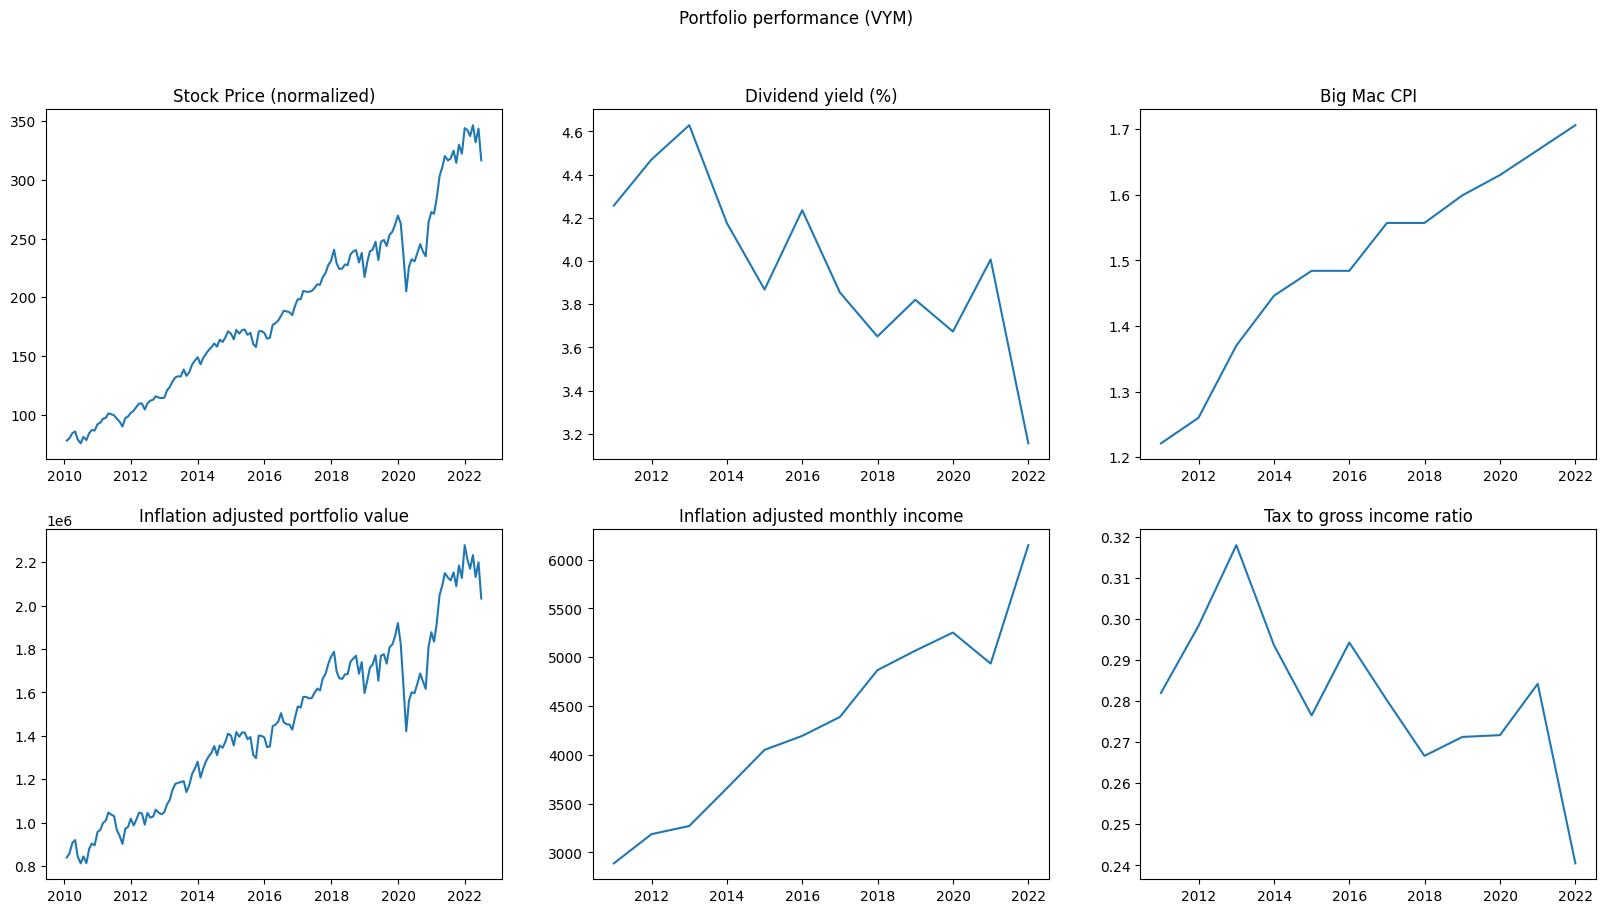

In [18]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))  # Adjust nrows and ncols based on the number of plots
fig.suptitle(f'Portfolio performance ({ticker})')
axs[0, 0].plot(df['timestamp'], df['price'])
axs[0, 0].set_title('Stock Price (normalized)')
axs[0, 1].plot(yearly['timestamp'], yearly['dividend yield'] * 100)
axs[0, 1].set_title('Dividend yield (%)')

axs[0, 2].plot(yearly['timestamp'], yearly['cpi'])
axs[0, 2].set_title('Big Mac CPI')

axs[1, 0].plot(df['timestamp'], df["infl. adj. portfolio value"])
axs[1, 0].set_title('Inflation adjusted portfolio value')

axs[1, 1].plot(yearly['timestamp'], yearly['infl. adj. monthly income'])
axs[1, 1].set_title('Inflation adjusted monthly income')

axs[1, 2].plot(yearly['timestamp'], yearly['tax/gross income ratio'])
axs[1, 2].set_title('Tax to gross income ratio')